# CS4487 Machine Learning | City University of Hong Kong
## Group Assignment - until 2019.12.13
- Tim Löhr       , EID: 40126684 
- Timo Bohnstedt , EID:
- Karina         , EID:

## 1.0 - Preprocessing

In [1]:
# Keras dependencies
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler

# Other usefull packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Using TensorFlow backend.
/Users/Loehr/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Loehr/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Loehr/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Loehr/anaconda3/lib/python3.6/site-packages/tenso

### 1.1 - Load the dataset and set the labels

In [2]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("X_train: " + str(x_train.shape))
print("y_train: " + str(y_train.shape))
print()
print("X_test: " + str(x_test.shape))
print("y_test: " + str(y_test.shape))

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)

X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


### 1.2 - Visualization of the training pictures

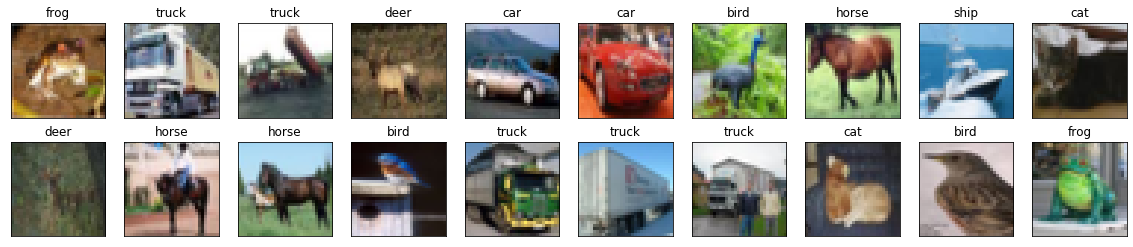

In [3]:
# The provided training data is correctly labeled to train on

fig = plt.figure(figsize=(20, 4))

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(x_train[:20][i], cmap='gray')
    ax.set_title(classes[y_train[:20][i].item()])

In [4]:
# Adaptive Learning for reaching a faster and better accuracy/loss

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

### 1.3 - Data manipulatiom

In [5]:
x_train = stats.zscore(x_train)
x_test = stats.zscore(x_test)

In [6]:
#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')

#z-score
#mean = np.mean(x_train,axis=(0,1,2,3))
#std = np.std(x_train,axis=(0,1,2,3))
#x_train = (x_train-mean)/(std+1e-7)
#x_test = (x_test-mean)/(std+1e-7)


# Converts our input class vector (50000, 1) to a binary output class matrix (50000, 10)
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [7]:
#data augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    fill_mode='constant',
    cval=0.
    )

datagen.fit(x_train)

In [8]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 2.0 - Model

In [9]:
weight_decay = 1e-4

In [27]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [11]:
# build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg2=None
num_filters2=32
adm2=keras.optimizers.Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.5
drop_conv2=0

model2 = Sequential()

model2.add(Conv2D(num_filters2, (3, 3), activation='relu', kernel_regularizer=reg2, input_shape=(x_train.shape[1:]),padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters

model2.add(Conv2D(2*num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(2*num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)

model2.add(Conv2D(4*num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization()
model2.add(Conv2D(4*num_filters2, (3, 3), activation='relu',kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization()
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dense(512, activation='relu',kernel_regularizer=reg2))
model2.add(BatchNormalization())
model2.add(Dropout(drop_dense2))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

SyntaxError: invalid syntax (<ipython-input-11-5d74d113256c>, line 27)

## 3.0 Model Training

### 3.1 - Fit model 

In [49]:
#training
batch_size = 128

sgd = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=500, 
                    epochs=1,
                    verbose=1,
                    validation_data=(x_test,y_test),
                    callbacks=[LearningRateScheduler(lr_schedule)])

IndentationError: unexpected indent (<ipython-input-49-1d4e65749345>, line 9)

In [48]:
# train with image augmentaion
history2=model2.fit_generator(datagen.flow(x_train, y_train, batch_size=128), steps_per_epoch = len(x_train) / 128, epochs=1, validation_data=(x_test, y_test))

ValueError: Error when checking target: expected dense_3 to have shape (10,) but got array with shape (1,)

### 3.2 - Save model

In [ ]:
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')    

scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))